# Analysing Time Series using Sax

This notebook contains a propototype approach for analyzing time series data.
The main goals of these applications are to:
1. Interactive view of the data (zoom in/out, show info when hovering over)
2. Cluster *windows* (consecutive series of data-points) based on similarity
3. Visualise the clusters in some way

The applications are to be used in a large-scale data context. Thus the clustering and retrieval of similar windows should be fast. There are algorithms that compare the raw data of all windows to eachother (e.g. DTW), but this has a time-complexity of O(n^2), which is way too big for big data.

A faster way to cluster windows is to define a window to a fixed length symbol. If the length of the symbol is fixed, we can assign each window to a bucket. A cluster would then be all the elements within the bucket. Would we recieve a (new) window, we can simply compute the according symbol and find all similar windows.

One example of this is Symbolic Aggregate approXimation (SAX). SAX is used to transform a sequence of rational numbers (i.e., a time series) into a sequence of letters (i.e., a string).


We start of with a simple dataset containing weather information from 2013-2017. The code below shows a snippet of the dataset

In [1]:
import pandas as pd

df = pd.read_csv("DailyDelhiClimateTrain.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000

Too keep things simple, we will only use the mean temperature variable (meantemp) for our testing data.

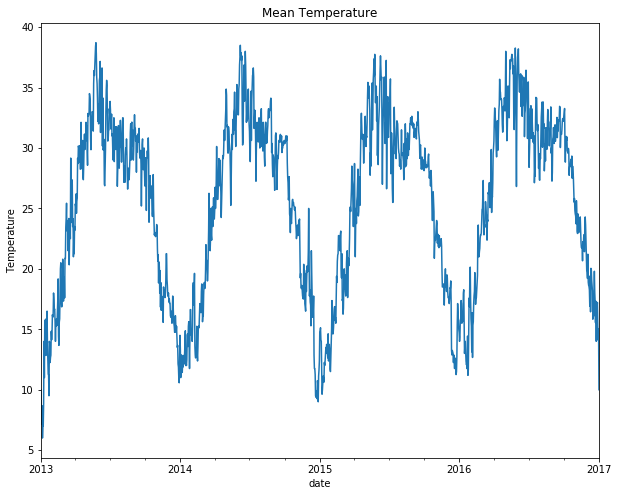

In [2]:
import matplotlib.pyplot as plt

meantemp = df.loc[:, 'meantemp'].copy()
meantemp.head()
meantemp.plot(figsize = (10, 8));
plt.ylabel('Temperature'); plt.title('Mean Temperature');

Next we cluster the windows using the **saxpy** library. The parameters for the clustering are as follows:
*window_size*: The size (number of data points) of one window.
*step_size*: The size (number of data points) in between each window. If the window_size is not absurdly small, chances are high that the window starting at data point *n* will be almost identical to the one at data point *n+1*. Because this is not very interesting for a data analyst, it's better to keep some distance between windows.
*paa_size*: The number of letters in one symbol.
*cut_size*: The number of existing letters.

The output of this code is a dictionary with for every symbol (cluster) a list of indexes of the windows contained in the cluster

In [3]:
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize #alphabet size

sax_dict = {}
# step_size = not used right now, step size = window size
window_size = 180
paa_size = 3
cut_size = 3

for i in range(int(len(meantemp.values)/window_size)):
    dat = meantemp.values[(i*window_size):(i*window_size)+window_size]
    dat_znorm = znorm(dat)
    dat_paa = paa(dat_znorm, paa_size)
    word = ts_to_string(dat_paa, cuts_for_asize(cut_size))
    if word not in sax_dict:
        sax_dict[word] = []
    sax_dict[word].append(i*window_size)
    
# Next line is a built-in function which automatically does what we have above, except we can not choose the step size :(
# sax_dict = sax_via_window(meantemp, win_size=100, paa_size=3, alphabet_size=3, nr_strategy=None)

print(sax_dict)

{'abc': [0, 360, 720, 1080], 'cca': [180, 900, 1260], 'cba': [540]}


Now that we have cluster information, it's time to visualize it. We start of with a simple visualization, where for each cluster we can see all the datapoints on the raw data that correspond to it.

In [4]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

fig = go.FigureWidget()

# fig.add_trace(
#     go.Scatter(x=meantemp.index, y=meantemp.values)
# )

default_size = 5
delta_size = 2
default_opacity = 0.3

# Draw a trace for every symbol (which may contain multiple windows)
for symbol in sax_dict:
    xvalues = []
    yvalues = []
    for i in sax_dict[symbol]:
        xvalues.extend(meantemp.index[i:i+window_size])
        yvalues.extend(meantemp.values[i:i+window_size])
    fig.add_trace(
        go.Scatter(
            x=xvalues + xvalues,
            y=yvalues + [0] * len(yvalues),
            name=symbol,
            mode='markers',
            marker=dict(
                size=default_size,
                opacity=0.5,
            )
        )
    )

# Update the figure when clicked on a point, so we can highlight the clicked trace
def update_trace(trace, points, selector):
    if len(points.point_inds) > 0:
        for i in range( len(fig.data) ):
            fig.data[i].marker.size = default_size + delta_size * (i == points.trace_index)
            fig.data[i].marker.opacity = default_opacity + (1-default_opacity) * (i == points.trace_index)

# Add the update function to the click event on each trace
for i in range( len(fig.data) ):
    fig.data[i].on_click(update_trace)

# Add some styling
layout = go.Layout(
    title='Mean Temperature',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Temperature'),
    hovermode='closest',
    hoverdistance=-1
)
fig.update_layout(layout)

# Print figure
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.5, 'size': 5},
              'mode': 'markers',
         …

Next we add subfigures for each similar window for the selected window

In [5]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from ipywidgets import VBox, HBox

image = VBox([fig])

# Now also display the windows that have the same symbol as the selected window
def update_trace(trace, points, selector):
    if len(points.point_inds) > 0:
        for i in range( len(fig.data) ):
            fig.data[i].marker.size = default_size + delta_size * (i == points.trace_index)
            fig.data[i].marker.opacity = default_opacity + (1-default_opacity) * (i == points.trace_index)
            if i == points.trace_index:
                image.children = (fig,)
                for window in sax_dict[fig.data[i].name]:
                    f = go.FigureWidget()
                    f.add_trace(
                        go.Scatter(x=meantemp.index[window: window + window_size], y=meantemp.values[window: window + window_size])
                    )
                    image.children += (f,)
                        
# Add the update function to the click event on each trace
for i in range( len(fig.data) ):
    fig.data[i].on_click(update_trace)                    

# Display the image
image

    'data': [{'marker': {'opacity': 0.5, 'size': 5},
              'mode': 'mark…